## MESHTAL file

```{eval-rst}
The complete API can be found at :py:class:`f4enix.output.meshtal.Meshtal`
```

It is possible to parse and MCNP meshtal file and obtain a pyvista
object for each of the fmeshes.

In [ ]:
# import the related module and parse a meshtal file
from f4enix.output.meshtal import Meshtal

# file = 'mode0_plasma_prod.msht'
file = 'meshtal'
meshtal = Meshtal(file)

# By default all meshes are parsed, but if speed up is needed, only a subset
# of them can be selected
meshtal.readMesh()
meshtal

In [ ]:
import tempfile  # To have a scratch directory for the example
outpath = tempfile.gettempdir()

# fmeshes can be dumped all together 
meshtal.write_all(outpath, out_format='vtk')

# Or specifically with higher control
meshtal.mesh[1004].write(outpath, list_array_names=['Value - Total'],
                         out_format='ip_fluent', outfile='custom name')

instead of writing them all separate it could be useful to collapse all fmeshes
into a single pyvista grid. This is possible only if the fmeshes have the same
geometry and have no binning.

In [ ]:
# this dictionary provides the names for the value and error in each fmesh
dict_names = {1004: ['neutron flux', 'neutron flux err'],
              1024: ['photon flux', 'photon flux err']}
collapsed_grid = meshtal.collapse_grids(dict_names)
collapsed_grid

In [ ]:
# select a specific fmesh.
n_flux_fmesh = meshtal.mesh[1004]

# Access the related pyvista object and all its powerful methods
# The units from MCNP apply if no modification is made by the user
n_flux = n_flux_fmesh.grid
n_flux

In [ ]:
import pyvista as pv

try:
    pv.start_xvfb()
except OSError:
    # this is needed only on Linux headless servers
    pass

In [ ]:
# quick plot to check that the meshes are not empty
clip = n_flux.clip(normal='z')  # native pyvista clip
clip.plot(scalars='Value - Total', jupyter_backend='static')

In [ ]:
import pyvista as pv

# Load an .stl file to be used for plots and plot them with the fmesh to check
# that the units match. stl units will depend by export settings of the user
stl = pv.read('iter1D.stl').scale(10)  # scale the stl to have same units

# Set up and show a pyvista plotter
plotter = pv.Plotter()
plotter.add_mesh(clip)
plotter.add_mesh(stl, opacity=0.4)
plotter.show(jupyter_backend='static')

In [ ]:
# Load additional modules related to Atlas production
from f4enix.output.plotter import MeshPlotter, Atlas
from copy import deepcopy

# Get a basic PyVista mesh where to store all other data
global_mesh = deepcopy(meshtal.mesh[1004].grid)

# On the same grid, load all the different fmeshes results. In this case there
# are only two
for tally_num, fmesh in meshtal.mesh.items():
    # get the FC card comment for the fmesh to be used as name of the scalar
    name = fmesh.comment.strip()
    # get the scalar values
    data = fmesh.grid['Value - Total']
    # Adding the array to the global mesh
    global_mesh[name] = data

# Clean the original results from the template mesh
global_mesh.cell_data.remove('Value - Total')
global_mesh.cell_data.remove('Error - Total')

global_mesh

Another handy method from pyvista is the voxelization of stl file and subsequent mapping of pyvista grid onto these voxelized stl

In [ ]:
import pyvista as pv
divisions = 50 # increase this will lead to better detail (i.e. smaller size of voxels)
voxelized = pv.voxelize(stl, density=stl.length/divisions, check_surface=False)

voxelized.clip(normal='y').plot(jupyter_backend='static')

In [ ]:
mapped = voxelized.sample(meshtal.mesh[1004].grid)

plotter = pv.Plotter()
plotter.add_mesh(mapped.clip(normal='y'), scalars='Value - Total')
plotter.show(jupyter_backend='static')

### Slicing

There are different slicing methods that have been defined in F4Enix. All of them produces slices that can be automatically plotted in order to build an atlas.

In [ ]:
# Initialize the custom plotter with the mesh and stl
plotter = MeshPlotter(global_mesh, stl=stl)

# There are many default settings that can be modified, e.g.:
# plotter.legend_args['vertical'] = False

In [ ]:
# toroidal slicing. It can be done on all the 180 deg or specify the sector
# and origin
toroidal_slices = plotter.slice_toroidal(30)  # 30 deg. increment
# Show the first slice
print(toroidal_slices[0])  # (name of the slice, mesh slice, stl slice)

# Use pyvista native plotter just as an example to show what is the output
pv_plotter = pv.Plotter()
for slices in toroidal_slices:
    mesh_slice = slices[1]
    pv_plotter.add_mesh(mesh_slice)

pv_plotter.show(jupyter_backend='static')

#### Normal slicing

In [ ]:
# perform slices normal to the selected axis
horizontal_slices = plotter.slice_on_axis('z', 3)  # 3 slices from max to min
# Show the first slice
print(toroidal_slices[0])  # (name of the slice, mesh slice, stl slice)

# Use pyvista native plotter just as an example to show what is the output
pv_plotter = pv.Plotter()
for slices in horizontal_slices:
    mesh_slice = slices[1]
    pv_plotter.add_mesh(mesh_slice)

pv_plotter.show(jupyter_backend='static')

#### General slicing

In [ ]:
# General slicing using origin and normals for each slice
# [name, x, y, z, ux, uy, uz]
slices_param = [['slice1', 0, 0, 0, 1, 0, 0],
                ['slice2', 500, 700, 300, 0.5, 0.5, 0]]
general_slices = plotter.slice(slices_param)

# Use pyvista native plotter just as an example to show what is the output
pv_plotter = pv.Plotter()
for slices in general_slices:
    mesh_slice = slices[1]
    stl_slice = slices[2]
    pv_plotter.add_mesh(mesh_slice)
    pv_plotter.add_mesh(stl_slice)

pv_plotter.show(jupyter_backend='static')

### Build the Atlas

In [ ]:
pv.global_theme.allow_empty_mesh = True

# Time to plot the slices
meshtal = Meshtal("meshtal")
stl = pv.read("iter1D.stl")

meshtal.readMesh()
mesh = meshtal.mesh[1004].grid

plotter = MeshPlotter(mesh, stl.scale(10))


toroidal_slices = plotter.slice_toroidal(30)  # 30 deg. increment
horizontal_slices = plotter.slice_on_axis("z", 3)  # 3 slices from max to min
global_mesh = plotter.mesh
# Cycle on all the mesh quantities
sections = []
for array_name in global_mesh.array_names:

    # Arbitrary logic can be inserted here
    min_val = 1e6
    max_val = 1e15
    n_colors = 9
    min_max = (min_val, max_val)

    # Plot both the vertical and toroidal slice related to the quantity
    tot_images = []
    for slices in [toroidal_slices, horizontal_slices]:
        # Plot the slices
        images = plotter.plot_slices(
            slices, array_name, n_colors=n_colors, min_max=min_max
        )
        tot_images.extend(images)

    sections.append((array_name, tot_images))

# Show one of the images that will build the atlas
print(sections[0])
print(sections[0][1])
print(sections[0][1][-1])
sections[0][1][-1][1]

In [ ]:
import tempfile  # To have a scratch directory for the example

# Finally build the atlas. This can be built either from folders containing
# images, where each subfolder is interpreted as a new section, or adding each
# section manually. This second option is recommended since it allows to avoid
# saving the images to disk

# initialize the atlas
atlas = Atlas('Atlas example')

# Decrease the default width of plots (by default they occupy the entire text
# length)
atlas.default_width = atlas.default_width*0.9

# Build one section for each quantity
for arrayname, images in sections:
    atlas.add_section(arrayname, images)

outpath = tempfile.gettempdir()
print(outpath)  # We are saving in the default temporary directory
atlas.save(outpath)

### Add volume sampling error to CuV Meshtal files

We are going to calculate the volume with a Monte Carlo integral. A random sample of N points inside a voxel is done, checking for each point if it falls inside the studied cell.

$$V_r=1/N ∑_i b_i$$

Where $b_i$ is a random variable that follows a binomial distribution (0 or 1) depending on if the point fell inside the studied cell. $V_r$ is the partial cell volume over the voxel volume.
To  know the uncertainty of the estimator V_r we can apply the uncertainty propagation law, as each point is sampled independently.

$$ σ_{(V_r)}^2=∑_i((∂V_r)/(∂b_i ))^2⋅σ_{b_i}^2 =∑_i1/N^2 ⋅σ_{b_i}^2$$

All $b_i$ variables follow the same binomial probability distribution, that is, each point has the same chance to fall in the cell. Therefore, $σ_{(b_i)}^2=σ_b^2$ . Then we can make the sum so:

$$σ_{V_r}^2=(σ_b^2)/N$$

Where $σ_b^2$ can be calculated via the variance numeric estimator.

$$σ_b^2=〈b^2 〉-〈b〉^2$$

Up to this point, we have seen the same procedure as in many Monte Carlo integrals. For example, that if MCNP as seen in page 2-109 of the MCNP5 Manual I.However, the volume we are calculating is a binomial (0 or 1).

$$〈b〉≈1/N ∑_ib_i =V_r$$
$$〈b^2 〉≈1/N ∑_ib_i^2 =1/N ∑_ib_i =V_r$$

Therefore: 

$$σ_{(V_r)}^2=(σ_b^2)/N=(〈b^2 〉-〈b〉^2)/N=(V_r-V_r^2)/N$$

In [ ]:
import tempfile  # To have a scratch directory for the example
import os
import pyvista as pv
from f4enix.output.meshtal import Meshtal
from f4enix.output.cuv_sampling_error import add_sampling_error_to_vtk

# Read a meshtal and create a VTK file
meshtal = Meshtal("meshtal_cuv")
meshtal.readMesh()

# write to vtk
tmpdir = tempfile.gettempdir()
outname = 'outfile'
outpath = os.path.join(tmpdir, outname)
meshtal.mesh[44].write(tmpdir, outfile=outname)

# Read the VTK file
grid = pv.read(os.path.join(tmpdir, outname + '.vtr'))

# The amount of sampling points per voxel should be identified from the MCNP input file
# by the user. In this example, it is set to 1000 points per voxel.
grid_with_errors = add_sampling_error_to_vtk(
        grid=grid, cuv_file_path="meshtal_cuv", voxel_sampling_points=1000
    )
grid_with_errors

## Apply transformations to FMESH grids

It is possible to apply transformations to the FMESH tally grids of the meshtal file, given a MCNP TR card.
The most standard way is by applying a TR card to a FMESH grid:

In [ ]:
from numjuggler import parser
from f4enix.output.meshtal import Meshtal

# Define a -20 degrees rotation around the z axis with MCNP syntax
tr_text = ["*TR1 0 0 0 20.0000 70.0000 90 110.0000 20.0000 90 90 90 0\n"]

## Generate the transformation card
mcnp_transformation = parser.Card(tr_text, 5, 0)
mcnp_transformation.get_values()

# Read the meshtal file
meshtal = Meshtal("meshtal_transform")
meshtal.readMesh()

# Select the mesh to be transformed
mesh_tally_2024 = meshtal.mesh[2024]

# Plot the original mesh
mesh_tally_2024.grid.plot(scalars="Value - Total", show_edges=True, jupyter_backend='static')

# Apply the transformation to the mesh
mesh_tally_2024.apply_transformation(mcnp_transformation)

# Plot the transformed mesh
mesh_tally_2024.grid.plot(scalars="Value - Total", show_edges=True, jupyter_backend='static')

You can also apply multiple transformations to multiple meshes, just by providing a dictionary.

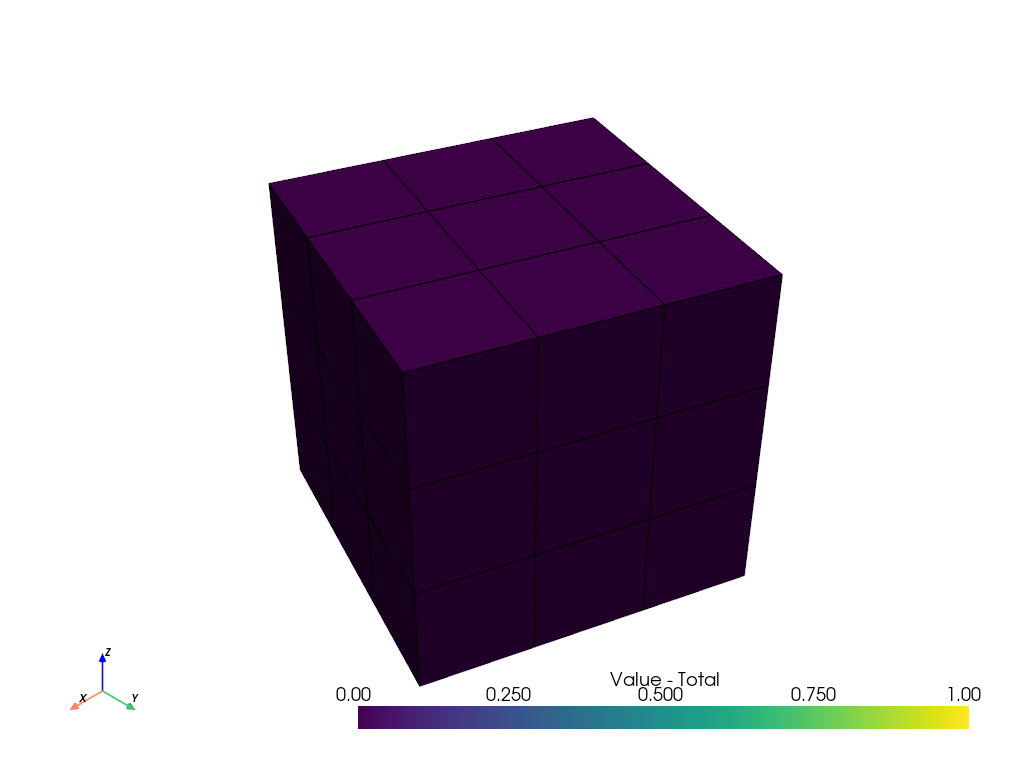

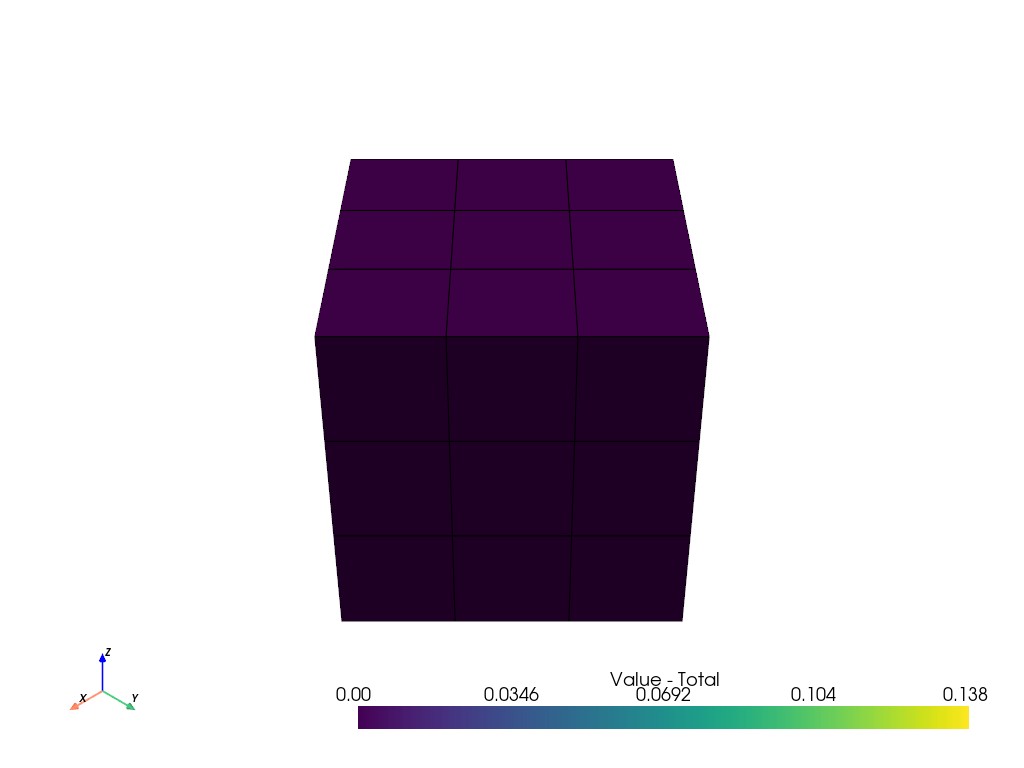

In [12]:
from numjuggler import parser
from f4enix.output.meshtal import Meshtal
# Define a -20 degrees rotation around the z axis with MCNP syntax
tr_rotation_1_text = ["*TR1 0 0 0 20.0000 70.0000 90 110.0000 20.0000 90 90 90 0\n"]
# Define a -45 degrees rotation around the z axis with MCNP syntax
tr_rotation_2_text = ["*TR1 0 0 0 45.0000 45.0000 90 135.0000 45.0000 90 90 90 0\n"]

## Generate the transformation cards
mcnp_transformation_1 = parser.Card(tr_rotation_1_text, 5, 0)
mcnp_transformation_1.get_values()

mcnp_transformation_2 = parser.Card(tr_rotation_2_text, 5, 0)
mcnp_transformation_2.get_values()

# Read the meshtal file
meshtal = Meshtal("meshtal_transform")
meshtal.readMesh()

dict_transformation = {2024: mcnp_transformation_1,
                       2124: mcnp_transformation_2}

meshtal.transform_multiple_fmesh(dict_transformation)

# Select the mesh with the first transformation
mesh_tally_2024 = meshtal.mesh[2024]

# Plot the transformed mesh
mesh_tally_2024.grid.plot(scalars="Value - Total", show_edges=True, jupyter_backend='static')

# Select the mesh with the second transformation
mesh_tally_2124 = meshtal.mesh[2124]

# Plot the transformed mesh
mesh_tally_2124.grid.plot(scalars="Value - Total", show_edges=True, jupyter_backend='static')

Moreover, you can provide F4Enix with an Input object and let F4Enix transform all FMESH tallies
according to the corresponding tr=... labels assigned to each FMESH card in the input

In [11]:
from f4enix.input.MCNPinput import Input
from f4enix.output.meshtal import Meshtal

# Read the meshtal file
meshtal = Meshtal("meshtal_transform")
meshtal.readMesh()

inp = Input.from_input("transforms.i")

meshtal.transform_fmesh(inp)